In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array

In [ ]:
# Path to images and masks
images_path = "/content/drive/MyDrive/DATASET/png/Original"
masks_path = "/content/drive/MyDrive/DATASET/png/Ground Truth"

# Get a list of image and mask file names
image_files = sorted(os.listdir(images_path))
mask_files = sorted(os.listdir(masks_path))

# Function to load and preprocess images and masks
def load_data(image_files, mask_files, img_size=(256, 256)):
    images = []
    masks = []

    for img_file, mask_file in zip(image_files, mask_files):
        # Load image
        img = cv2.imread(os.path.join(images_path, img_file))
        img = cv2.resize(img, img_size)
        img = img.astype(np.float32) / 255.0  # Normalize the image to [0, 1]

        # Load mask
        mask = cv2.imread(os.path.join(masks_path, mask_file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size)
        mask = mask.astype(np.float32) / 255.0  # Normalize mask to [0, 1]
        mask = np.expand_dims(mask, axis=-1)  # Add a channel dimension

        images.append(img_to_array(img))
        masks.append(img_to_array(mask))

    return np.array(images), np.array(masks)

# Load images and masks
images, masks = load_data(image_files, mask_files)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout


In [ ]:
def unet_model(input_size=(256, 256, 3)):
    # Define the U-Net architecture
    inputs = Input(input_size)

    # Encoder (downsampling)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder (upsampling)
    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    # Define the model
    model = Model(inputs=[inputs], outputs=[outputs])

    # Ensure the model object is returned
    return model

In [ ]:
# Create the U-Net model
model = unet_model()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=16, epochs=5)

Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 3809s 123s/step - accuracy: 0.7936 - loss: 16.9516 - val_accuracy: 0.9132 - val_loss: 0.2975
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 3819s 121s/step - accuracy: 0.9042 - loss: 0.2829 - val_accuracy: 0.9132 - val_loss: 0.2340
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 3804s 122s/step - accuracy: 0.9072 - loss: 0.2440 - val_accuracy: 0.9132 - val_loss: 0.2197
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 3797s 121s/step - accuracy: 0.9068 - loss: 0.2393 - val_accuracy: 0.9132 - val_loss: 0.2113
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 3792s 121s/step - accuracy: 0.8969 - loss: 0.2436 - val_accuracy: 0.9132 - val_loss: 0.2322


4/4 ━━━━━━━━━━━━━━━━━━━━ 263s 65s/step - accuracy: 0.9103 - loss: 0.2335
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


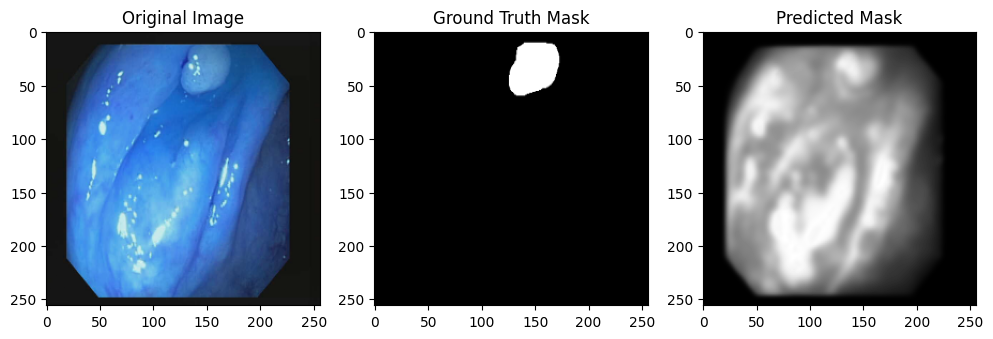

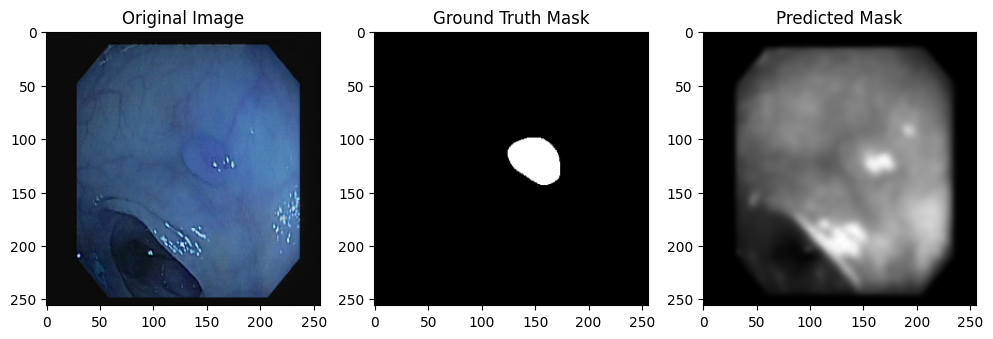

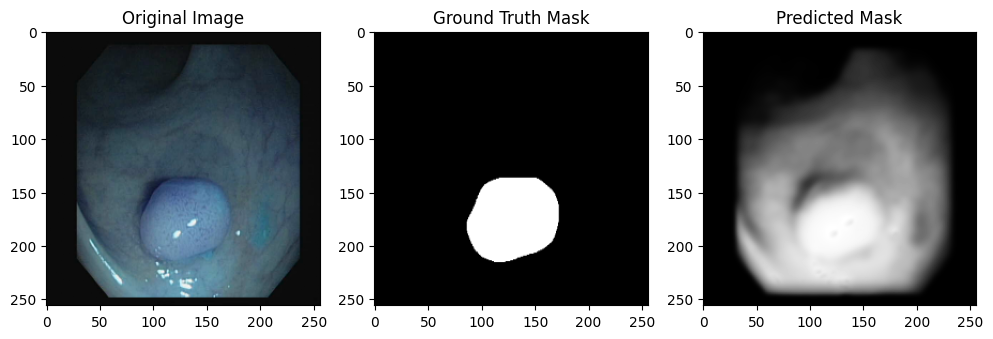

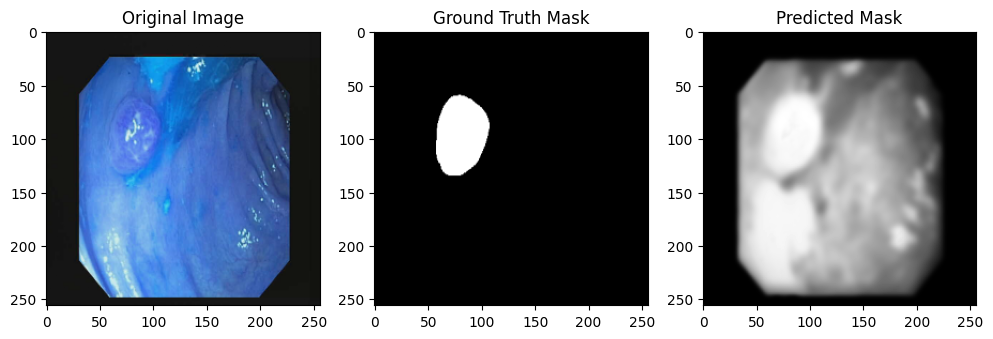

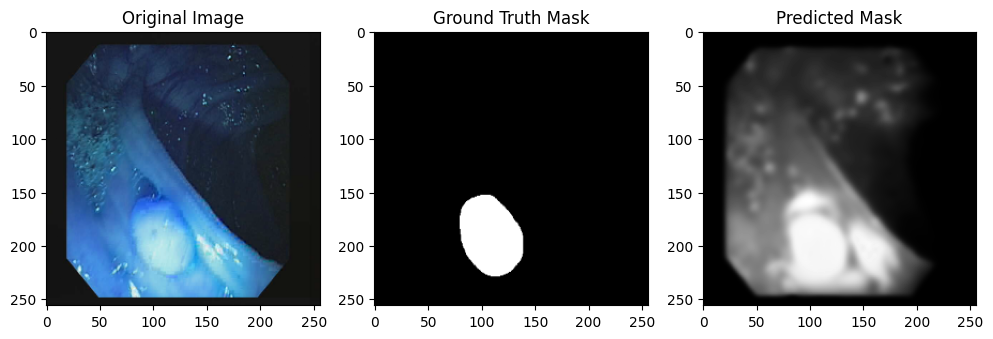

In [ ]:
import matplotlib.pyplot as plt

# Evaluate on test set
model.evaluate(X_test, y_test)

# Predict on a few test images
predictions = model.predict(X_test[:5])

# Visualize the results
for i in range(5):
    plt.figure(figsize=(12, 4))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i])
    plt.title('Original Image')

    # Ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(y_test[i].squeeze(), cmap='gray')
    plt.title('Ground Truth Mask')

    # Predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(predictions[i].squeeze(), cmap='gray')
    plt.title('Predicted Mask')

    plt.show()

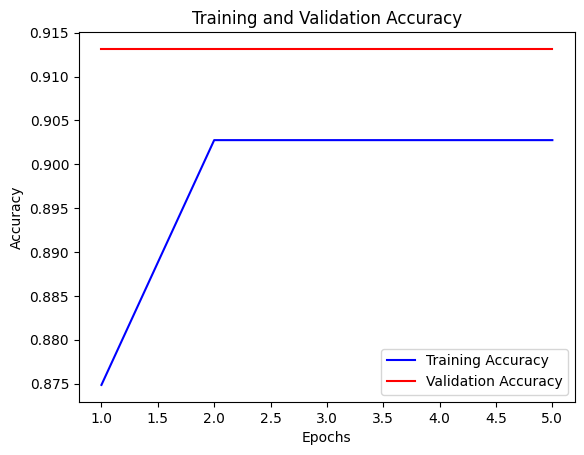

Final Training Accuracy: 0.9027529358863831
Final Validation Accuracy: 0.9131531715393066


In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the training history object from model.fit()
# Access the history for accuracy and val_accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plotting the accuracy
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Calculate and print the final accuracy values
final_train_accuracy = accuracy[-1]
final_val_accuracy = val_accuracy[-1]

print(f"Final Training Accuracy: {final_train_accuracy}")
print(f"Final Validation Accuracy: {final_val_accuracy}")